In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from prophet import Prophet
import datetime
import holidays
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
def wape(y_true: np.array, y_pred: np.array):
    return np.sum(np.abs(y_true-y_pred))/np.sum(np.abs(y_true))

In [8]:
train = pd.read_csv("data/train_preprocessed_w_features.csv")
train['day'] = pd.to_datetime(train['day'], format="%Y-%m-%d")
train['month'] = pd.DatetimeIndex(train['day']).month
train['year'] = pd.DatetimeIndex(train['day']).year
train['sell_in'] = train['supplier_price']/train['num_sales']
train['price'] = train['selling_price']/train['num_sales']
train_df = train.groupby(["day", "shop_id", "sku"]).agg({"price": "mean", "num_sales": "sum", 
                                                         "count": "mean", "sell_in": "mean", "month": "first",
                                                         "promo_id": "first", "discount": "mean"}).reset_index()

In [216]:
model = CatBoostRegressor()
model.load_model("catboost_final")

In [786]:
from catboost import CatBoostRegressor
from scipy.optimize import curve_fit
from random import randint

def calc_price_series(p, delta, n):
    if not n%2:
        return np.linspace(p*max(0,(1-delta)), p*(1+delta), n+1)
    else:
        return np.linspace(p*max(0,(1-delta)), p*(1+delta), n)
        
def calc_price_map(price_vector, delta, n):
    price_vector = price_vector.apply(lambda p: calc_price_series(p, delta, n))
    price_map = pd.DataFrame(price_vector.to_list())
    price_map.columns = [str(c) for c in price_map.columns]
    return price_map

def prognose_demand(model, horizon, price_map):
    horizon_tmp = horizon.copy()
    elast_table = price_map.copy()
    elast_table.columns = [c + '_price' for c in elast_table.columns]
    '''
    calculate dbd prognosis for each date in horizon for a range of prices
    horizon - test subset aXb where a - number of days, b - feature space dimension
    returns aXn prediction table
    '''
    elast_table.columns = [c + '_price' for c in price_map.columns]
    for c in price_map.columns:
        horizon_tmp['price'] = price_map[c]
        pcn = c + '_quantity_prediction'
        elast_table[pcn] =  model.predict(horizon_tmp)
        elast_table.loc[elast_table[pcn] < 0,pcn] = 0 # нужно фиксить в катбусте
    return elast_table

def random_point(scope_df):
    sku_list = list(scope_df.sku.unique())
    sku = sku_list[randint(0,len(sku_list))]
    shop_list = list(scope_df[scope_df.sku == sku].shop_id.unique())
    shop_id = shop_list[randint(0,len(shop_list))]
    return({'shop_id':shop_id,'sku':sku})

def revenue(prices, quantities):
    revenues = prices.reset_index(drop=True)*quantities.reset_index(drop=True)
    revenues = np.round(revenues, 2)
    return revenues
def opt_rev(revenues):
    return revenues.max()
def opt_rev_id(revenues):
    revenues = revenues.astype(float)
    return revenues.idxmax()
def opt_price(prices, n):
    return prices.iloc[n]

def find_optimum_point(res_series, precision=2):
    prices = np.round(res_series.filter(regex='price'), precision)
    quantities = np.round(res_series.filter(regex='quantity'), precision)
    revenues = np.round(revenue(prices, quantities), precision)
    return opt_price(prices, opt_rev_id(revenues)), opt_rev(revenues)

def find_optimum_col(elast_table):
    optimum = elast_table.apply(lambda row: find_optimum_point(row), axis=1)
    elast_table['opt_revenue'] = optimum.apply(lambda l: l[1])
    elast_table['opt_price'] = optimum.apply(lambda l: l[0])
    elast_table['opt_quantity'] = np.round(elast_table['opt_revenue']/elast_table['opt_price'], 0)
    
def prognose_assortiment_demand(model, assortiment, shift_delta, n_points):
    '''
    assortiment - whole excel table format: sku - shop_id - dates - <features for each tuple>
    <features> - price, sell_in, month, promo_id, discount
    '''
    if 'id' not in assortiment.columns:
        assortiment['id'] = range(len(assortiment))
    assort_predicted_elast = []
    for sku in tqdm(assortiment.sku.unique()):
        one_sku_df = assortiment[assortiment.sku == sku]
        for shop_id in one_sku_df.shop_id.unique():
            train_df = one_sku_df[one_sku_df.shop_id == shop_id]
            days = train_df.day
            train_df = train_df[['price','count','sell_in','month','promo_id','discount','id']].reset_index(drop=True)
            price_map = calc_price_map(train_df.price, shift_delta, n_points)
            shop_sku_prog = prognose_demand(model, train_df, price_map)
            shop_sku_prog['id'] = train_df['id']
            assort_predicted_elast.append(shop_sku_prog)
    assort_predicted_elast = pd.concat(assort_predicted_elast, ignore_index=True)
    return assort_predicted_elast

def optimize_assortiment(assort_predicted_elast):
    find_optimum_col(assort_predicted_elast)
    return assort_predicted_elast[['id','opt_price','opt_revenue', 'opt_quantity']]

def elasticity_plot(pred, samples = [0], opt=None):
    rev = [(pred.filter(regex='quantity').iloc[x].reset_index(drop=True)*pred.filter(regex='price').iloc[x].reset_index(drop=True)) for x in samples if x in pred.index]
    pr = [pred.filter(regex='price').iloc[x].reset_index(drop=True) for x in samples if x in pred.index]
    for r, p in zip(rev, pr):
        the_plot = sns.lineplot(y = r, x=p)
    plt.legend(labels=samples)
    the_plot.set(xlabel='price', ylabel='revenue')
    
def demand_plot(pred, samples = [0], opt=None):
    qua = [pred.filter(regex='_quantity').iloc[x].reset_index(drop=True) for x in samples if x in pred.index]
    pr = [pred.filter(regex='_price').iloc[x].reset_index(drop=True) for x in samples if x in pred.index]
    for r, p in zip(qua, pr):
        the_plot = sns.lineplot(y = r, x=p)
    plt.legend(labels=samples)
    the_plot.set(xlabel='price', ylabel='demand')

In [838]:
def select_good_skus(assortiment, 
                     threshold_count=60, 
                     threshold_dates=['2021-06-01','2021-06-30'], 
                     threshold_size=60):
    if threshold_count:
        assortiment_cut = assortiment[assortiment['count'] >= threshold_count]
    if threshold_dates:
        date1 = pd.to_datetime(threshold_dates[0])
        date2 = pd.to_datetime(threshold_dates[1])
        assortiment_cut = assortiment_cut[(assortiment_cut.day >= date1) & (assortiment_cut.day <= date2)]
    if threshold_size:
        assortiment_cut = assortiment_cut.head(threshold_size+1)
    return assortiment_cut

def compare(assortiment, optimized_prices):
    assort = assortiment.merge(optimized_prices, how='left', on='id')
    assort['price'] = np.round(assort['price'], 2)
    assort['revenue'] = np.round(assort['price']*assort['num_sales'], 2)
    assort = assort.rename(columns={
        'num_sales': 'base_quantity',
        'price': 'base_price',
        'revenue': 'base_revenue'
    })
    assort['revenue_relative_uplift'] = np.round((assort['opt_revenue']-assort['base_revenue'])/assort['base_revenue'],2)
    return assort

In [803]:
train_df

,day,shop_id,sku,price,num_sales,count,sell_in,month,promo_id,discount
0,2018-01-01,0,749,34.990000,1.000,19.000000,24.730000,1,30488,12.40
1,2018-01-01,0,14189,82.495308,5.338,81.600000,55.721249,1,145965,173.22
2,2018-01-01,0,17984,18.490000,3.000,38.769231,10.500000,1,115458,61.20
3,2018-01-01,0,26276,99.772329,2.284,1390.976190,95.683012,1,233553,96.68
4,2018-01-01,0,28071,142.090000,1.000,2.482759,120.360000,1,164866,71.59
...,...,...,...,...,...,...,...,...,...,...
18010809,2021-06-30,59,119082,199.990000,1.000,24.333333,124.320000,6,57722,179.00
18010810,2021-06-30,59,119230,94.390000,1.000,6.416667,52.510000,6,51588,5.00
18010811,2021-06-30,59,119233,35.990000,3.000,31.750000,13.340000,6,211652,18.60
18010812,2021-06-30,59,121008,89.990000,2.000,4.615385,55.535000,6,51588,9.60


In [840]:
threshold_count = int(input('введите нижнюю границу среднего числа продаж по сети в месяц: '))
threshold_date1 = input('введите дату начала периода (формат гггг-мм-дд): ')
threshold_date2 = input('введите дату конца периода (формат гггг-мм-дд): ')
threshold_size = int(input('введите ограничение на число прогнозируемых точек: '))
train_df_whole_sample = select_good_skus(train_df, threshold_count=threshold_count, 
                                         threshold_dates=[threshold_date1, threshold_date2],
                                         threshold_size=threshold_size)
train_df_whole_sample['id'] = train_df_whole_sample.index + 1

введите нижнюю границу среднего числа продаж по сети в месяц:  60
введите дату начала периода (формат гггг-мм-дд):  2021-06-01
введите дату конца периода (формат гггг-мм-дд):  2021-06-30
введите ограничение на число прогнозируемых точек:  50


In [841]:
prognose = prognose_assortiment_demand(model, train_df_whole_sample, 1, 100)

100%|██████████| 49/49 [00:20<00:00,  2.44it/s]


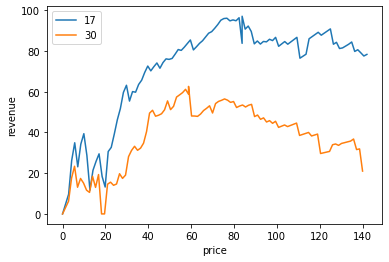

In [826]:
elasticity_plot(prognose, samples=[17,30])

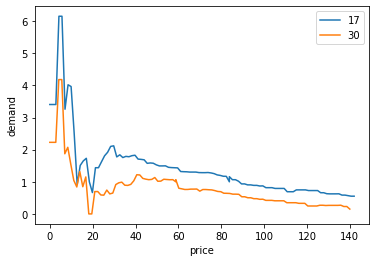

In [827]:
demand_plot(prognose, samples=[17,30])

In [828]:
optimized_assort = optimize_assortiment(prognose)
optimized_assort.head()

,id,opt_price,opt_revenue,opt_quantity
0,17572464,57.66,172.98,3.0
1,17572645,119.89,239.78,2.0
2,17572466,168.30,65.64,0.0
3,17572467,154.82,154.82,1.0
4,17572480,274.49,296.45,1.0


In [833]:
comparisson_df = compare(train_df_whole_sample, optimized_assort)

In [842]:
comparisson_df.head()

,day,shop_id,sku,base_price,base_quantity,count,sell_in,month,promo_id,discount,id,opt_price,opt_revenue,opt_quantity,base_revenue,revenue_relative_uplift
0,2021-06-01,0,17,28.83,0.880,450.878049,64.000000,6,195006,44.1,17572464,57.66,172.98,3.0,25.37,5.82
1,2021-06-01,0,69,85.00,0.556,64.926829,28.507194,6,51588,2.5,17572466,168.30,65.64,0.0,47.26,0.39
2,2021-06-01,0,218,97.99,1.000,213.357143,44.060000,6,46654,23.1,17572467,154.82,154.82,1.0,97.99,0.58
3,2021-06-01,0,13180,224.99,1.000,493.880952,182.720000,6,51588,11.9,17572480,274.49,296.45,1.0,224.99,0.32
4,2021-06-01,0,13194,36.89,1.000,332.595238,26.570000,6,230787,21.0,17572481,59.76,74.70,1.0,36.89,1.02


<AxesSubplot:>

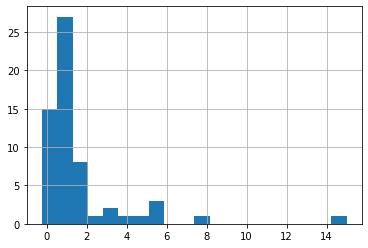

In [844]:
comparisson_df.revenue_relative_uplift.hist(bins=20)

In [ ]:
comparisson_df.to_excel('comparisson_stats.xlsx')